<a href="https://colab.research.google.com/github/manhhad32/ParkingLot/blob/master/SpeechEmotionCNN2D20250426.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making the most of your colab subscription



## Faster GPUs

<p>Users who have purchased one of Colab's paid plans have access to faster GPUs and more memory. You can upgrade your notebook's GPU settings in <code>Runtime &gt; Change runtime type</code> in the menu to select from several accelerator options, subject to availability.</p>
<p>The free-of-charge version of Colab grants access to Nvidia's T4 GPUs subject to quota restrictions and availability.</p>

You can see what GPU you've been assigned at any time by executing the following cell. If the execution result of running the code cell below is 'Not connected to a GPU', you can change the runtime by going to <code>Runtime &gt; Change runtime type</code> in the menu to enable a GPU accelerator, and then re-execute the code cell.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [1]:
!pip install gdown

In [3]:
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import glob
from collections import Counter
import zipfile
from google.colab import drive
import gdown

In [4]:
# Ví dụ link: https://drive.google.com/file/d/1AbCDEFGHIJKLMNOPQR/view?usp=sharing
# Chỉ cần ID: "1AbCDEFGHIJKLMNOPQR"
# https://drive.google.com/file/d/1BAKWfFtM3WqQQAa4mS5SMDAlKnPhV3mD/view?usp=sharing
file_id = "1BAKWfFtM3WqQQAa4mS5SMDAlKnPhV3mD"
output_zip = "emotion_train.zip"

# Tạo link tải trực tiếp từ file_id
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_zip, quiet=False)

# Bước 2: Giải nén file zip
output_folder = "emotion_train"
os.makedirs(output_folder, exist_ok=True)

with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(output_folder)


Downloading...
From (original): https://drive.google.com/uc?id=1BAKWfFtM3WqQQAa4mS5SMDAlKnPhV3mD
From (redirected): https://drive.google.com/uc?id=1BAKWfFtM3WqQQAa4mS5SMDAlKnPhV3mD&confirm=t&uuid=f5a08942-cc23-461b-a763-55788b5668f5
To: /content/emotion_train.zip
100%|██████████| 1.16G/1.16G [00:15<00:00, 73.6MB/s]


In [5]:
file_test_id = "1OSG1oPq1ahQwEx7N3Wy3QG3j5mDkd6DJ"
output_test_zip = "emotion_test.zip"

# Tạo link tải trực tiếp từ file_id
gdown.download(f"https://drive.google.com/uc?id={file_test_id}", output_test_zip, quiet=False)

# Bước 2: Giải nén file zip
output_test_folder = "emotion_test"
# The following line was changed
os.makedirs(output_test_folder, exist_ok=True)
# It was previously trying to create a directory with the same name as your zip file

with zipfile.ZipFile(output_test_zip, 'r') as zip_ref:
    zip_ref.extractall(output_test_folder)

Downloading...
From (original): https://drive.google.com/uc?id=1OSG1oPq1ahQwEx7N3Wy3QG3j5mDkd6DJ
From (redirected): https://drive.google.com/uc?id=1OSG1oPq1ahQwEx7N3Wy3QG3j5mDkd6DJ&confirm=t&uuid=7a9d73e3-ea1d-4077-8e37-523f778c7e7b
To: /content/emotion_test.zip
100%|██████████| 42.6M/42.6M [00:00<00:00, 54.7MB/s]


In [7]:
import shutil # Import the shutil module at the top of your code
folder_path = '/content/emotion_test/__MACOSX'  # Đường dẫn thư mục cần xóa

# Kiểm tra thư mục có tồn tại không rồi xóa
if os.path.exists(folder_path):
    shutil.rmtree(folder_path) # Now you can use shutil.rmtree
    print(f"✅ Đã xóa thư mục: {folder_path}")
else:
    print(f"⚠️ Thư mục không tồn tại: {folder_path}")

✅ Đã xóa thư mục: /content/emotion_test/__MACOSX


In [8]:
# Danh sách cảm xúc từ VNEMOS
EMOTIONS = ['Angry', 'Happy', 'Sad', 'Neutral', 'Disgusted', 'Fearful', 'Suprised']
NUM_CLASSES = len(EMOTIONS)

# Hàm thêm nhiễu
def add_noise(audio, noise_factor=0.005):
    noise = np.random.randn(len(audio))
    return audio + noise_factor * noise

# Hàm thay đổi cao độ
def pitch_shift(audio, sr, n_steps=1.5):
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

# Hàm kéo giãn thời gian
def time_stretch(audio, rate=1.05):
    return librosa.effects.time_stretch(audio, rate=rate)

# Hàm dịch chuyển thời gian
def time_shift(audio, shift_max=0.2, sr=16000):
    shift = int(np.random.uniform(-shift_max, shift_max) * sr)
    return np.roll(audio, shift)

# Trích xuất MFCC với nhiều loại augmentation
def extract_mfcc(audio_path, sample_rate=16000, duration=5, n_mfcc=26, n_frames=157, augment_type='normal'):
    audio, sr = librosa.load(audio_path, sr=sample_rate)
    target_length = sample_rate * duration

    # Chuẩn hóa độ dài
    if len(audio) < target_length:
        audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
    else:
        audio = audio[:target_length]

    # Áp dụng augmentation theo loại
    if augment_type == 'noise':
        audio = add_noise(audio)
    elif augment_type == 'pitch':
        audio = pitch_shift(audio, sr)
    elif augment_type == 'stretch':
        audio = time_stretch(audio)
    elif augment_type == 'shift':
        audio = time_shift(audio)
    # 'normal' thì giữ nguyên

    hop_length = target_length // (n_frames - 1)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=2048)
    if mfcc.shape[1] > n_frames:
        mfcc = mfcc[:, :n_frames]
    elif mfcc.shape[1] < n_frames:
        mfcc = np.pad(mfcc, ((0, 0), (0, n_frames - mfcc.shape[1])), mode='constant')

    return np.expand_dims(mfcc, axis=-1)

# Chuẩn bị dữ liệu với ánh xạ nhãn từ thư mục
def prepare_training_data(audio_files, emotion_map):
    X, y = [], []
    augment_types = ['normal', 'noise', 'pitch', 'stretch', 'shift']

    for audio_path in audio_files:
        folder_name = os.path.basename(os.path.dirname(audio_path))
        emotion_idx = emotion_map.get(folder_name, -1)
        if emotion_idx == -1:
            print(f"Warning: {audio_path} không thuộc danh sách cảm xúc, bỏ qua.")
            continue

        for aug_type in augment_types:
            mfcc = extract_mfcc(str(audio_path), augment_type=aug_type)
            X.append(mfcc)
            y.append(emotion_idx)

    X = np.array(X)
    y = to_categorical(y, num_classes=NUM_CLASSES)
    print(f"Dataset shape: X={X.shape}, y={y.shape}")
    return X, y

# Xây dựng mô hình CNN cải tiến
def build_cnn_2d(input_shape=(26, 157, 1)):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    model.summary()
    return model

# Huấn luyện và đánh giá
def train_and_evaluate_model(model, X, y, epochs=200, batch_size=16, checkpoint_path='best_model.h5'):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}")

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                  metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.00001)
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping, reduce_lr, checkpoint],
                        verbose=1)

    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"\nĐánh giá trên tập kiểm tra:")
    print(f" - Loss: {val_loss:.4f}")
    print(f" - Accuracy: {val_accuracy:.4f}")
    return model, history

# Dự đoán trực tiếp bằng CNN
def predict_emotion(audio_path, model):
    mfcc = extract_mfcc(audio_path, augment_type='normal')
    mfcc = np.expand_dims(mfcc, axis=0)
    prediction = model.predict(mfcc, verbose=0)
    predicted_emotion_idx = np.argmax(prediction, axis=1)[0]
    return EMOTIONS[predicted_emotion_idx]

# Vẽ biểu đồ Loss
def plot_loss_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

Phân bố nhãn gốc: Counter({'Sad': 2137, 'Angry': 2116, 'Happy': 2105, 'Fearful': 1986, 'Disgusted': 1795, 'Neutral': 1755, 'Suprised': 557})
Dataset shape: X=(62255, 26, 157, 1), y=(62255, 7)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 157, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 157, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 157, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 26, 157, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 78, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 78, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 78, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 13, 78, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 78, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 13, 78, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 39, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 39, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 39, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 6, 39, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 19, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 19, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7296)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,868,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,009,959 (7.67 MB)

 Trainable params: 2,009,319 (7.66 MB)

 Non-trainable params: 640 (2.50 KB)

Train shape: (49804, 26, 157, 1), Val shape: (12451, 26, 157, 1)
Epoch 1/200
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3187 - loss: 2.5097
Epoch 1: val_loss improved from inf to 1.93310, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - accuracy: 0.3187 - loss: 2.5096 - val_accuracy: 0.5131 - val_loss: 1.9331 - learning_rate: 1.0000e-04
Epoch 2/200
3109/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5020 - loss: 1.9086
Epoch 2: val_loss improved from 1.93310 to 1.64179, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.5020 - loss: 1.9085 - val_accuracy: 0.5898 - val_loss: 1.6418 - learning_rate: 1.0000e-04
Epoch 3/200
3102/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5640 - loss: 1.6609
Epoch 3: val_loss improved from 1.64179 to 1.44400, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.5640 - loss: 1.6608 - val_accuracy: 0.6510 - val_loss: 1.4440 - learning_rate: 1.0000e-04
Epoch 4/200
3104/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6068 - loss: 1.5203
Epoch 4: val_loss improved from 1.44400 to 1.37234, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6068 - loss: 1.5202 - val_accuracy: 0.6739 - val_loss: 1.3723 - learning_rate: 1.0000e-04
Epoch 5/200
3108/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6415 - loss: 1.4318
Epoch 5: val_loss improved from 1.37234 to 1.28488, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.6415 - loss: 1.4318 - val_accuracy: 0.7101 - val_loss: 1.2849 - learning_rate: 1.0000e-04
Epoch 6/200
3110/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6723 - loss: 1.3608
Epoch 6: val_loss improved from 1.28488 to 1.22845, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6723 - loss: 1.3608 - val_accuracy: 0.7378 - val_loss: 1.2285 - learning_rate: 1.0000e-04
Epoch 7/200
3103/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7009 - loss: 1.3074
Epoch 7: val_loss improved from 1.22845 to 1.17341, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.7009 - loss: 1.3074 - val_accuracy: 0.7563 - val_loss: 1.1734 - learning_rate: 1.0000e-04
Epoch 8/200
3103/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7285 - loss: 1.2507
Epoch 8: val_loss improved from 1.17341 to 1.14556, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.7285 - loss: 1.2507 - val_accuracy: 0.7723 - val_loss: 1.1456 - learning_rate: 1.0000e-04
Epoch 9/200
3110/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7491 - loss: 1.2054
Epoch 9: val_loss improved from 1.14556 to 1.10323, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.7491 - loss: 1.2054 - val_accuracy: 0.7925 - val_loss: 1.1032 - learning_rate: 1.0000e-04
Epoch 10/200
3105/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7654 - loss: 1.1736
Epoch 10: val_loss did not improve from 1.10323
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.7654 - loss: 1.1736 - val_accuracy: 0.7986 - val_loss: 1.1050 - learning_rate: 1.0000e-04
Epoch 11/200
3112/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7838 - loss: 1.1458
Epoch 11: val_loss improved from 1.10323 to 1.04382, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.7838 - loss: 1.1458 - val_accuracy: 0.8303 - val_loss: 1.0438 - learning_rate: 1.0000e-04
Epoch 12/200
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8025 - loss: 1.1149
Epoch 12: val_loss improved from 1.04382 to 1.01598, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8025 - loss: 1.1149 - val_accuracy: 0.8452 - val_loss: 1.0160 - learning_rate: 1.0000e-04
Epoch 13/200
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8184 - loss: 1.0870
Epoch 13: val_loss improved from 1.01598 to 1.01225, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8184 - loss: 1.0870 - val_accuracy: 0.8510 - val_loss: 1.0123 - learning_rate: 1.0000e-04
Epoch 14/200
3102/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8307 - loss: 1.0704
Epoch 14: val_loss improved from 1.01225 to 0.98840, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8307 - loss: 1.0704 - val_accuracy: 0.8594 - val_loss: 0.9884 - learning_rate: 1.0000e-04
Epoch 15/200
3110/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8412 - loss: 1.0513
Epoch 15: val_loss improved from 0.98840 to 0.98636, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8412 - loss: 1.0513 - val_accuracy: 0.8624 - val_loss: 0.9864 - learning_rate: 1.0000e-04
Epoch 16/200
3109/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8510 - loss: 1.0363
Epoch 16: val_loss improved from 0.98636 to 0.97532, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8510 - loss: 1.0363 - val_accuracy: 0.8694 - val_loss: 0.9753 - learning_rate: 1.0000e-04
Epoch 17/200
3103/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8601 - loss: 1.0220
Epoch 17: val_loss improved from 0.97532 to 0.94778, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8601 - loss: 1.0220 - val_accuracy: 0.8881 - val_loss: 0.9478 - learning_rate: 1.0000e-04
Epoch 18/200
3112/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8699 - loss: 1.0052
Epoch 18: val_loss improved from 0.94778 to 0.94555, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8699 - loss: 1.0052 - val_accuracy: 0.8888 - val_loss: 0.9455 - learning_rate: 1.0000e-04
Epoch 19/200
3107/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8762 - loss: 0.9923
Epoch 19: val_loss improved from 0.94555 to 0.92794, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8762 - loss: 0.9923 - val_accuracy: 0.8974 - val_loss: 0.9279 - learning_rate: 1.0000e-04
Epoch 20/200
3101/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8824 - loss: 0.9871
Epoch 20: val_loss did not improve from 0.92794
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8824 - loss: 0.9871 - val_accuracy: 0.9003 - val_loss: 0.9282 - learning_rate: 1.0000e-04
Epoch 21/200
3103/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8855 - loss: 0.9776
Epoch 21: val_loss improved from 0.92794 to 0.91653, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8855 - loss: 0.9776 - val_accuracy: 0.9043 - val_loss: 0.9165 - learning_rate: 1.0000e-04
Epoch 22/200
3104/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8928 - loss: 0.9662
Epoch 22: val_loss improved from 0.91653 to 0.90657, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8928 - loss: 0.9662 - val_accuracy: 0.9097 - val_loss: 0.9066 - learning_rate: 1.0000e-04
Epoch 23/200
3110/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8959 - loss: 0.9595
Epoch 23: val_loss improved from 0.90657 to 0.90362, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8958 - loss: 0.9595 - val_accuracy: 0.9121 - val_loss: 0.9036 - learning_rate: 1.0000e-04
Epoch 24/200
3102/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8964 - loss: 0.9569
Epoch 24: val_loss improved from 0.90362 to 0.89438, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8964 - loss: 0.9569 - val_accuracy: 0.9168 - val_loss: 0.8944 - learning_rate: 1.0000e-04
Epoch 25/200
3104/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8977 - loss: 0.9517
Epoch 25: val_loss improved from 0.89438 to 0.89192, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8976 - loss: 0.9517 - val_accuracy: 0.9185 - val_loss: 0.8919 - learning_rate: 1.0000e-04
Epoch 26/200
3109/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9031 - loss: 0.9466
Epoch 26: val_loss improved from 0.89192 to 0.89109, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9031 - loss: 0.9467 - val_accuracy: 0.9148 - val_loss: 0.8911 - learning_rate: 1.0000e-04
Epoch 27/200
3103/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9064 - loss: 0.9384
Epoch 27: val_loss improved from 0.89109 to 0.88454, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9064 - loss: 0.9384 - val_accuracy: 0.9255 - val_loss: 0.8845 - learning_rate: 1.0000e-04
Epoch 28/200
3108/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9099 - loss: 0.9327
Epoch 28: val_loss improved from 0.88454 to 0.87863, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9099 - loss: 0.9327 - val_accuracy: 0.9230 - val_loss: 0.8786 - learning_rate: 1.0000e-04
Epoch 29/200
3112/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9093 - loss: 0.9311
Epoch 29: val_loss did not improve from 0.87863
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9093 - loss: 0.9311 - val_accuracy: 0.9190 - val_loss: 0.8829 - learning_rate: 1.0000e-04
Epoch 30/200
3110/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9114 - loss: 0.9280
Epoch 30: val_loss did not improve from 0.87863
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9114 - loss: 0.9280 - val_accuracy: 0.9169 - val_loss: 0.8901 - learning_rate: 1.0000e-04
Epoch 31/200
3104/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9146 - loss: 0.9210
Epoch 31: val_loss improved from 0.87863 to 0.87764, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9146 - loss: 0.9210 - val_accuracy: 0.9190 - val_loss: 0.8776 - learning_rate: 1.0000e-04
Epoch 32/200
3108/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9160 - loss: 0.9184
Epoch 32: val_loss improved from 0.87764 to 0.87571, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9160 - loss: 0.9184 - val_accuracy: 0.9226 - val_loss: 0.8757 - learning_rate: 1.0000e-04
Epoch 33/200
3103/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9134 - loss: 0.9181
Epoch 33: val_loss improved from 0.87571 to 0.87078, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9134 - loss: 0.9181 - val_accuracy: 0.9277 - val_loss: 0.8708 - learning_rate: 1.0000e-04
Epoch 34/200
3101/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9181 - loss: 0.9143
Epoch 34: val_loss improved from 0.87078 to 0.86446, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9181 - loss: 0.9143 - val_accuracy: 0.9284 - val_loss: 0.8645 - learning_rate: 1.0000e-04
Epoch 35/200
3103/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9197 - loss: 0.9072
Epoch 35: val_loss did not improve from 0.86446
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9197 - loss: 0.9072 - val_accuracy: 0.9179 - val_loss: 0.8843 - learning_rate: 1.0000e-04
Epoch 36/200
3102/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9182 - loss: 0.9104
Epoch 36: val_loss did not improve from 0.86446
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9182 - loss: 0.9104 - val_accuracy: 0.9255 - val_loss: 0.8709 - learning_rate: 1.0000e-04
Epoch 37/200
3111/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9242 - loss: 0.9008
Epoch 37: val_loss did not improve from 0.86446
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9242 - loss: 0.9009 - val_accuracy: 0.9159 - val_loss: 0.8800 - learning_rate: 1.000

3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9213 - loss: 0.9023 - val_accuracy: 0.9312 - val_loss: 0.8591 - learning_rate: 1.0000e-04
Epoch 40/200
3103/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9241 - loss: 0.9001
Epoch 40: val_loss did not improve from 0.85915
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9241 - loss: 0.9002 - val_accuracy: 0.9243 - val_loss: 0.8677 - learning_rate: 1.0000e-04
Epoch 41/200
3109/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9234 - loss: 0.8989
Epoch 41: val_loss improved from 0.85915 to 0.85529, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9234 - loss: 0.8989 - val_accuracy: 0.9301 - val_loss: 0.8553 - learning_rate: 1.0000e-04
Epoch 42/200
3112/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9246 - loss: 0.8945
Epoch 42: val_loss did not improve from 0.85529
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9246 - loss: 0.8945 - val_accuracy: 0.9249 - val_loss: 0.8605 - learning_rate: 1.0000e-04
Epoch 43/200
3106/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9239 - loss: 0.8949
Epoch 43: val_loss improved from 0.85529 to 0.85431, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9239 - loss: 0.8949 - val_accuracy: 0.9297 - val_loss: 0.8543 - learning_rate: 1.0000e-04
Epoch 44/200
3106/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9261 - loss: 0.8894
Epoch 44: val_loss improved from 0.85431 to 0.85287, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9261 - loss: 0.8894 - val_accuracy: 0.9319 - val_loss: 0.8529 - learning_rate: 1.0000e-04
Epoch 45/200
3110/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9255 - loss: 0.8888
Epoch 45: val_loss did not improve from 0.85287
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9255 - loss: 0.8888 - val_accuracy: 0.9280 - val_loss: 0.8567 - learning_rate: 1.0000e-04
Epoch 46/200
3105/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9271 - loss: 0.8878
Epoch 46: val_loss improved from 0.85287 to 0.84918, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9270 - loss: 0.8878 - val_accuracy: 0.9327 - val_loss: 0.8492 - learning_rate: 1.0000e-04
Epoch 47/200
3109/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9281 - loss: 0.8873
Epoch 47: val_loss did not improve from 0.84918
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9280 - loss: 0.8873 - val_accuracy: 0.9270 - val_loss: 0.8552 - learning_rate: 1.0000e-04
Epoch 48/200
3107/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9302 - loss: 0.8815
Epoch 48: val_loss did not improve from 0.84918
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9301 - loss: 0.8815 - val_accuracy: 0.9228 - val_loss: 0.8631 - learning_rate: 1.0000e-04
Epoch 49/200
3111/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9279 - loss: 0.8856
Epoch 49: val_loss improved from 0.84918 to 0.84288, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9279 - loss: 0.8856 - val_accuracy: 0.9347 - val_loss: 0.8429 - learning_rate: 1.0000e-04
Epoch 50/200
3103/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9270 - loss: 0.8866
Epoch 50: val_loss improved from 0.84288 to 0.83995, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9270 - loss: 0.8866 - val_accuracy: 0.9339 - val_loss: 0.8400 - learning_rate: 1.0000e-04
Epoch 51/200
3108/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9294 - loss: 0.8798
Epoch 51: val_loss improved from 0.83995 to 0.83686, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9293 - loss: 0.8798 - val_accuracy: 0.9387 - val_loss: 0.8369 - learning_rate: 1.0000e-04
Epoch 52/200
3109/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9279 - loss: 0.8827
Epoch 52: val_loss did not improve from 0.83686
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9279 - loss: 0.8827 - val_accuracy: 0.9302 - val_loss: 0.8517 - learning_rate: 1.0000e-04
Epoch 53/200
3107/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9293 - loss: 0.8776
Epoch 53: val_loss did not improve from 0.83686
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9293 - loss: 0.8776 - val_accuracy: 0.9312 - val_loss: 0.8456 - learning_rate: 1.0000e-04
Epoch 54/200
3110/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9294 - loss: 0.8778
Epoch 54: val_loss did not improve from 0.83686
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9294 - loss: 0.8778 - val_accuracy: 0.9326 - val_loss: 0.8414 - learning_rate: 1.000

3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9310 - loss: 0.8738 - val_accuracy: 0.9361 - val_loss: 0.8357 - learning_rate: 1.0000e-04
Epoch 59/200
3107/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9332 - loss: 0.8700
Epoch 59: val_loss improved from 0.83569 to 0.82991, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9331 - loss: 0.8701 - val_accuracy: 0.9415 - val_loss: 0.8299 - learning_rate: 1.0000e-04
Epoch 60/200
3110/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9327 - loss: 0.8723
Epoch 60: val_loss did not improve from 0.82991
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9327 - loss: 0.8723 - val_accuracy: 0.9288 - val_loss: 0.8480 - learning_rate: 1.0000e-04
Epoch 61/200
3110/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9311 - loss: 0.8704
Epoch 61: val_loss improved from 0.82991 to 0.82736, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9311 - loss: 0.8704 - val_accuracy: 0.9396 - val_loss: 0.8274 - learning_rate: 1.0000e-04
Epoch 62/200
3111/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9315 - loss: 0.8726
Epoch 62: val_loss did not improve from 0.82736
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9315 - loss: 0.8726 - val_accuracy: 0.9377 - val_loss: 0.8346 - learning_rate: 1.0000e-04
Epoch 63/200
3103/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9323 - loss: 0.8689
Epoch 63: val_loss did not improve from 0.82736
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9322 - loss: 0.8690 - val_accuracy: 0.9353 - val_loss: 0.8375 - learning_rate: 1.0000e-04
Epoch 64/200
3104/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9316 - loss: 0.8717
Epoch 64: val_loss did not improve from 0.82736
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9316 - loss: 0.8718 - val_accuracy: 0.9342 - val_loss: 0.8337 - learning_rate: 1.000

3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9336 - loss: 0.8656 - val_accuracy: 0.9407 - val_loss: 0.8235 - learning_rate: 1.0000e-04
Epoch 69/200
3108/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9359 - loss: 0.8644
Epoch 69: val_loss did not improve from 0.82351
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9359 - loss: 0.8645 - val_accuracy: 0.9366 - val_loss: 0.8330 - learning_rate: 1.0000e-04
Epoch 70/200
3107/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9361 - loss: 0.8629
Epoch 70: val_loss did not improve from 0.82351
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9361 - loss: 0.8629 - val_accuracy: 0.9338 - val_loss: 0.8408 - learning_rate: 1.0000e-04
Epoch 71/200
3102/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9347 - loss: 0.8645
Epoch 71: val_loss did not improve from 0.82351
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9347 - loss: 0.8645 - val_accuracy: 0.9383 - val_loss: 0.8284 - learning_rate: 1.000

3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9334 - loss: 0.8619 - val_accuracy: 0.9430 - val_loss: 0.8230 - learning_rate: 1.0000e-04
Epoch 74/200
3101/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9358 - loss: 0.8604
Epoch 74: val_loss improved from 0.82299 to 0.82248, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9358 - loss: 0.8604 - val_accuracy: 0.9413 - val_loss: 0.8225 - learning_rate: 1.0000e-04
Epoch 75/200
3110/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9320 - loss: 0.8627
Epoch 75: val_loss improved from 0.82248 to 0.82049, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9320 - loss: 0.8627 - val_accuracy: 0.9433 - val_loss: 0.8205 - learning_rate: 1.0000e-04
Epoch 76/200
3103/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9342 - loss: 0.8624
Epoch 76: val_loss did not improve from 0.82049
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9342 - loss: 0.8625 - val_accuracy: 0.9394 - val_loss: 0.8260 - learning_rate: 1.0000e-04
Epoch 77/200
3112/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9376 - loss: 0.8578
Epoch 77: val_loss did not improve from 0.82049
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9376 - loss: 0.8578 - val_accuracy: 0.9341 - val_loss: 0.8333 - learning_rate: 1.0000e-04
Epoch 78/200
3108/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9383 - loss: 0.8552
Epoch 78: val_loss did not improve from 0.82049
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9383 - loss: 0.8552 - val_accuracy: 0.9397 - val_loss: 0.8244 - learning_rate: 1.000

3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9360 - loss: 0.8574 - val_accuracy: 0.9415 - val_loss: 0.8181 - learning_rate: 1.0000e-04
Epoch 80/200
3100/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9385 - loss: 0.8580
Epoch 80: val_loss did not improve from 0.81810
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9385 - loss: 0.8580 - val_accuracy: 0.9400 - val_loss: 0.8222 - learning_rate: 1.0000e-04
Epoch 81/200
3109/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9393 - loss: 0.8549
Epoch 81: val_loss did not improve from 0.81810
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9393 - loss: 0.8549 - val_accuracy: 0.9374 - val_loss: 0.8305 - learning_rate: 1.0000e-04
Epoch 82/200
3107/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9368 - loss: 0.8565
Epoch 82: val_loss did not improve from 0.81810
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9368 - loss: 0.8565 - val_accuracy: 0.9394 - val_loss: 0.8237 - learning_rate: 1.000

3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9371 - loss: 0.8556 - val_accuracy: 0.9454 - val_loss: 0.8141 - learning_rate: 1.0000e-04
Epoch 84/200
3103/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9392 - loss: 0.8542
Epoch 84: val_loss did not improve from 0.81408
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9392 - loss: 0.8542 - val_accuracy: 0.9373 - val_loss: 0.8228 - learning_rate: 1.0000e-04
Epoch 85/200
3102/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9375 - loss: 0.8559
Epoch 85: val_loss did not improve from 0.81408
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9375 - loss: 0.8559 - val_accuracy: 0.9350 - val_loss: 0.8265 - learning_rate: 1.0000e-04
Epoch 86/200
3101/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9367 - loss: 0.8576
Epoch 86: val_loss did not improve from 0.81408
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9367 - loss: 0.8577 - val_accuracy: 0.9403 - val_loss: 0.8236 - learning_rate: 1.000

3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9533 - loss: 0.8255 - val_accuracy: 0.9592 - val_loss: 0.7746 - learning_rate: 2.0000e-05
Epoch 95/200
3112/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9632 - loss: 0.7986
Epoch 95: val_loss improved from 0.77457 to 0.76661, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9632 - loss: 0.7986 - val_accuracy: 0.9580 - val_loss: 0.7666 - learning_rate: 2.0000e-05
Epoch 96/200
3108/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9673 - loss: 0.7803
Epoch 96: val_loss improved from 0.76661 to 0.75328, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9673 - loss: 0.7803 - val_accuracy: 0.9607 - val_loss: 0.7533 - learning_rate: 2.0000e-05
Epoch 97/200
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9698 - loss: 0.7684
Epoch 97: val_loss improved from 0.75328 to 0.74428, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9698 - loss: 0.7684 - val_accuracy: 0.9623 - val_loss: 0.7443 - learning_rate: 2.0000e-05
Epoch 98/200
3112/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9715 - loss: 0.7574
Epoch 98: val_loss improved from 0.74428 to 0.73804, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9715 - loss: 0.7574 - val_accuracy: 0.9611 - val_loss: 0.7380 - learning_rate: 2.0000e-05
Epoch 99/200
3102/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9733 - loss: 0.7489
Epoch 99: val_loss improved from 0.73804 to 0.73428, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9733 - loss: 0.7489 - val_accuracy: 0.9605 - val_loss: 0.7343 - learning_rate: 2.0000e-05
Epoch 100/200
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9745 - loss: 0.7408
Epoch 100: val_loss improved from 0.73428 to 0.72331, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9745 - loss: 0.7408 - val_accuracy: 0.9643 - val_loss: 0.7233 - learning_rate: 2.0000e-05
Epoch 101/200
3104/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9749 - loss: 0.7339
Epoch 101: val_loss improved from 0.72331 to 0.71691, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9749 - loss: 0.7339 - val_accuracy: 0.9657 - val_loss: 0.7169 - learning_rate: 2.0000e-05
Epoch 102/200
3104/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9757 - loss: 0.7269
Epoch 102: val_loss improved from 0.71691 to 0.71273, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9757 - loss: 0.7269 - val_accuracy: 0.9652 - val_loss: 0.7127 - learning_rate: 2.0000e-05
Epoch 103/200
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9756 - loss: 0.7225
Epoch 103: val_loss improved from 0.71273 to 0.70643, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9756 - loss: 0.7225 - val_accuracy: 0.9661 - val_loss: 0.7064 - learning_rate: 2.0000e-05
Epoch 104/200
3108/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9773 - loss: 0.7156
Epoch 104: val_loss improved from 0.70643 to 0.70406, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9773 - loss: 0.7156 - val_accuracy: 0.9654 - val_loss: 0.7041 - learning_rate: 2.0000e-05
Epoch 105/200
3110/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9770 - loss: 0.7104
Epoch 105: val_loss improved from 0.70406 to 0.69901, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9770 - loss: 0.7104 - val_accuracy: 0.9660 - val_loss: 0.6990 - learning_rate: 2.0000e-05
Epoch 106/200
3109/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9779 - loss: 0.7060
Epoch 106: val_loss improved from 0.69901 to 0.69758, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9779 - loss: 0.7060 - val_accuracy: 0.9642 - val_loss: 0.6976 - learning_rate: 2.0000e-05
Epoch 107/200
3108/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9790 - loss: 0.7014
Epoch 107: val_loss improved from 0.69758 to 0.69169, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9790 - loss: 0.7014 - val_accuracy: 0.9663 - val_loss: 0.6917 - learning_rate: 2.0000e-05
Epoch 108/200
3104/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9810 - loss: 0.6952
Epoch 108: val_loss improved from 0.69169 to 0.68584, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9810 - loss: 0.6952 - val_accuracy: 0.9672 - val_loss: 0.6858 - learning_rate: 2.0000e-05
Epoch 109/200
3102/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9793 - loss: 0.6933
Epoch 109: val_loss improved from 0.68584 to 0.68529, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9793 - loss: 0.6933 - val_accuracy: 0.9662 - val_loss: 0.6853 - learning_rate: 2.0000e-05
Epoch 110/200
3108/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9804 - loss: 0.6892
Epoch 110: val_loss improved from 0.68529 to 0.68004, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9804 - loss: 0.6892 - val_accuracy: 0.9682 - val_loss: 0.6800 - learning_rate: 2.0000e-05
Epoch 111/200
3103/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9794 - loss: 0.6870
Epoch 111: val_loss did not improve from 0.68004
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9794 - loss: 0.6870 - val_accuracy: 0.9655 - val_loss: 0.6824 - learning_rate: 2.0000e-05
Epoch 112/200
3105/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9797 - loss: 0.6836
Epoch 112: val_loss improved from 0.68004 to 0.67755, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9797 - loss: 0.6836 - val_accuracy: 0.9663 - val_loss: 0.6775 - learning_rate: 2.0000e-05
Epoch 113/200
3107/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9803 - loss: 0.6808
Epoch 113: val_loss improved from 0.67755 to 0.67641, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9803 - loss: 0.6808 - val_accuracy: 0.9651 - val_loss: 0.6764 - learning_rate: 2.0000e-05
Epoch 114/200
3111/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9811 - loss: 0.6778
Epoch 114: val_loss improved from 0.67641 to 0.67204, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9811 - loss: 0.6778 - val_accuracy: 0.9655 - val_loss: 0.6720 - learning_rate: 2.0000e-05
Epoch 115/200
3106/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9823 - loss: 0.6735
Epoch 115: val_loss improved from 0.67204 to 0.66774, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9823 - loss: 0.6735 - val_accuracy: 0.9661 - val_loss: 0.6677 - learning_rate: 2.0000e-05
Epoch 116/200
3106/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9803 - loss: 0.6737
Epoch 116: val_loss did not improve from 0.66774
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9803 - loss: 0.6737 - val_accuracy: 0.9660 - val_loss: 0.6679 - learning_rate: 2.0000e-05
Epoch 117/200
3108/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9828 - loss: 0.6696
Epoch 117: val_loss improved from 0.66774 to 0.66408, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9828 - loss: 0.6696 - val_accuracy: 0.9666 - val_loss: 0.6641 - learning_rate: 2.0000e-05
Epoch 118/200
3104/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9822 - loss: 0.6662
Epoch 118: val_loss did not improve from 0.66408
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9822 - loss: 0.6663 - val_accuracy: 0.9659 - val_loss: 0.6679 - learning_rate: 2.0000e-05
Epoch 119/200
3106/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9830 - loss: 0.6633
Epoch 119: val_loss improved from 0.66408 to 0.66318, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9830 - loss: 0.6633 - val_accuracy: 0.9669 - val_loss: 0.6632 - learning_rate: 2.0000e-05
Epoch 120/200
3112/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9818 - loss: 0.6618
Epoch 120: val_loss improved from 0.66318 to 0.66012, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9818 - loss: 0.6618 - val_accuracy: 0.9667 - val_loss: 0.6601 - learning_rate: 2.0000e-05
Epoch 121/200
3101/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9815 - loss: 0.6614
Epoch 121: val_loss did not improve from 0.66012
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9815 - loss: 0.6614 - val_accuracy: 0.9642 - val_loss: 0.6613 - learning_rate: 2.0000e-05
Epoch 122/200
3104/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9833 - loss: 0.6593
Epoch 122: val_loss improved from 0.66012 to 0.65833, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9833 - loss: 0.6593 - val_accuracy: 0.9669 - val_loss: 0.6583 - learning_rate: 2.0000e-05
Epoch 123/200
3112/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9834 - loss: 0.6567
Epoch 123: val_loss improved from 0.65833 to 0.65285, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9834 - loss: 0.6567 - val_accuracy: 0.9685 - val_loss: 0.6528 - learning_rate: 2.0000e-05
Epoch 124/200
3100/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9825 - loss: 0.6559
Epoch 124: val_loss did not improve from 0.65285
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9825 - loss: 0.6559 - val_accuracy: 0.9674 - val_loss: 0.6543 - learning_rate: 2.0000e-05
Epoch 125/200
3110/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9830 - loss: 0.6542
Epoch 125: val_loss improved from 0.65285 to 0.64939, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9830 - loss: 0.6542 - val_accuracy: 0.9692 - val_loss: 0.6494 - learning_rate: 2.0000e-05
Epoch 126/200
3102/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9831 - loss: 0.6513
Epoch 126: val_loss did not improve from 0.64939
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9831 - loss: 0.6513 - val_accuracy: 0.9663 - val_loss: 0.6548 - learning_rate: 2.0000e-05
Epoch 127/200
3105/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9840 - loss: 0.6497
Epoch 127: val_loss did not improve from 0.64939
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9840 - loss: 0.6497 - val_accuracy: 0.9679 - val_loss: 0.6526 - learning_rate: 2.0000e-05
Epoch 128/200
3106/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9832 - loss: 0.6500
Epoch 128: val_loss improved from 0.64939 to 0.64851, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9832 - loss: 0.6500 - val_accuracy: 0.9670 - val_loss: 0.6485 - learning_rate: 2.0000e-05
Epoch 129/200
3112/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9844 - loss: 0.6466
Epoch 129: val_loss did not improve from 0.64851
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9844 - loss: 0.6466 - val_accuracy: 0.9660 - val_loss: 0.6501 - learning_rate: 2.0000e-05
Epoch 130/200
3110/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9826 - loss: 0.6491
Epoch 130: val_loss improved from 0.64851 to 0.64576, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9826 - loss: 0.6491 - val_accuracy: 0.9682 - val_loss: 0.6458 - learning_rate: 2.0000e-05
Epoch 131/200
3104/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9842 - loss: 0.6457
Epoch 131: val_loss did not improve from 0.64576
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9842 - loss: 0.6457 - val_accuracy: 0.9670 - val_loss: 0.6478 - learning_rate: 2.0000e-05
Epoch 132/200
3109/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9822 - loss: 0.6457
Epoch 132: val_loss did not improve from 0.64576
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9822 - loss: 0.6457 - val_accuracy: 0.9670 - val_loss: 0.6492 - learning_rate: 2.0000e-05
Epoch 133/200
3111/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9840 - loss: 0.6434
Epoch 133: val_loss did not improve from 0.64576
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9840 - loss: 0.6434 - val_accuracy: 0.9638 - val_loss: 0.6484 - learning_rate:

3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9841 - loss: 0.6410 - val_accuracy: 0.9689 - val_loss: 0.6419 - learning_rate: 2.0000e-05
Epoch 137/200
3104/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9843 - loss: 0.6380
Epoch 137: val_loss did not improve from 0.64190
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9842 - loss: 0.6380 - val_accuracy: 0.9665 - val_loss: 0.6444 - learning_rate: 2.0000e-05
Epoch 138/200
3104/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9846 - loss: 0.6388
Epoch 138: val_loss did not improve from 0.64190
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9846 - loss: 0.6388 - val_accuracy: 0.9659 - val_loss: 0.6426 - learning_rate: 2.0000e-05
Epoch 139/200
3106/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9840 - loss: 0.6375
Epoch 139: val_loss improved from 0.64190 to 0.64077, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9840 - loss: 0.6375 - val_accuracy: 0.9677 - val_loss: 0.6408 - learning_rate: 2.0000e-05
Epoch 140/200
3112/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9852 - loss: 0.6354
Epoch 140: val_loss improved from 0.64077 to 0.63788, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9852 - loss: 0.6354 - val_accuracy: 0.9680 - val_loss: 0.6379 - learning_rate: 2.0000e-05
Epoch 141/200
3112/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9843 - loss: 0.6358
Epoch 141: val_loss did not improve from 0.63788
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9843 - loss: 0.6358 - val_accuracy: 0.9636 - val_loss: 0.6406 - learning_rate: 2.0000e-05
Epoch 142/200
3108/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9835 - loss: 0.6366
Epoch 142: val_loss did not improve from 0.63788
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9835 - loss: 0.6366 - val_accuracy: 0.9669 - val_loss: 0.6388 - learning_rate: 2.0000e-05
Epoch 143/200
3109/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9837 - loss: 0.6364
Epoch 143: val_loss did not improve from 0.63788
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9837 - loss: 0.6364 - val_accuracy: 0.9661 - val_loss: 0.6391 - learning_rate:

3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9839 - loss: 0.6336 - val_accuracy: 0.9682 - val_loss: 0.6350 - learning_rate: 2.0000e-05
Epoch 146/200
3105/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9861 - loss: 0.6311
Epoch 146: val_loss improved from 0.63496 to 0.63398, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9861 - loss: 0.6311 - val_accuracy: 0.9683 - val_loss: 0.6340 - learning_rate: 2.0000e-05
Epoch 147/200
3101/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9835 - loss: 0.6342
Epoch 147: val_loss did not improve from 0.63398
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9835 - loss: 0.6342 - val_accuracy: 0.9672 - val_loss: 0.6362 - learning_rate: 2.0000e-05
Epoch 148/200
3112/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9843 - loss: 0.6311
Epoch 148: val_loss improved from 0.63398 to 0.63364, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9843 - loss: 0.6311 - val_accuracy: 0.9680 - val_loss: 0.6336 - learning_rate: 2.0000e-05
Epoch 149/200
3104/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9844 - loss: 0.6299
Epoch 149: val_loss did not improve from 0.63364
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9844 - loss: 0.6299 - val_accuracy: 0.9677 - val_loss: 0.6341 - learning_rate: 2.0000e-05
Epoch 150/200
3110/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9844 - loss: 0.6299
Epoch 150: val_loss did not improve from 0.63364
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9844 - loss: 0.6299 - val_accuracy: 0.9651 - val_loss: 0.6356 - learning_rate: 2.0000e-05
Epoch 151/200
3104/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9847 - loss: 0.6307
Epoch 151: val_loss did not improve from 0.63364
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9847 - loss: 0.6307 - val_accuracy: 0.9656 - val_loss: 0.6354 - learning_rate:

3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9837 - loss: 0.6294 - val_accuracy: 0.9676 - val_loss: 0.6310 - learning_rate: 2.0000e-05
Epoch 157/200
3111/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9845 - loss: 0.6279
Epoch 157: val_loss did not improve from 0.63100
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9845 - loss: 0.6279 - val_accuracy: 0.9672 - val_loss: 0.6318 - learning_rate: 2.0000e-05
Epoch 158/200
3100/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9853 - loss: 0.6265
Epoch 158: val_loss improved from 0.63100 to 0.63094, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9853 - loss: 0.6265 - val_accuracy: 0.9677 - val_loss: 0.6309 - learning_rate: 2.0000e-05
Epoch 159/200
3109/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9844 - loss: 0.6271
Epoch 159: val_loss improved from 0.63094 to 0.62814, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9844 - loss: 0.6271 - val_accuracy: 0.9684 - val_loss: 0.6281 - learning_rate: 2.0000e-05
Epoch 160/200
3112/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9862 - loss: 0.6258
Epoch 160: val_loss did not improve from 0.62814
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9862 - loss: 0.6258 - val_accuracy: 0.9649 - val_loss: 0.6336 - learning_rate: 2.0000e-05
Epoch 161/200
3102/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9848 - loss: 0.6263
Epoch 161: val_loss did not improve from 0.62814
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9848 - loss: 0.6263 - val_accuracy: 0.9672 - val_loss: 0.6294 - learning_rate: 2.0000e-05
Epoch 162/200
3111/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9850 - loss: 0.6244
Epoch 162: val_loss did not improve from 0.62814
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9850 - loss: 0.6244 - val_accuracy: 0.9653 - val_loss: 0.6308 - learning_rate:

3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9852 - loss: 0.6232 - val_accuracy: 0.9663 - val_loss: 0.6276 - learning_rate: 2.0000e-05
Epoch 166/200
3107/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9846 - loss: 0.6233
Epoch 166: val_loss did not improve from 0.62761
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9846 - loss: 0.6233 - val_accuracy: 0.9665 - val_loss: 0.6293 - learning_rate: 2.0000e-05
Epoch 167/200
3105/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9857 - loss: 0.6228
Epoch 167: val_loss did not improve from 0.62761
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9857 - loss: 0.6228 - val_accuracy: 0.9640 - val_loss: 0.6314 - learning_rate: 2.0000e-05
Epoch 168/200
3107/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9856 - loss: 0.6223
Epoch 168: val_loss did not improve from 0.62761
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9856 - loss: 0.6223 - val_accuracy: 0.9656 - val_loss: 0.6293 - learning_rate:

3113/3113 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9851 - loss: 0.6221 - val_accuracy: 0.9665 - val_loss: 0.6249 - learning_rate: 2.0000e-05
Epoch 172/200
3110/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9859 - loss: 0.6204
Epoch 172: val_loss did not improve from 0.62489
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9859 - loss: 0.6204 - val_accuracy: 0.9636 - val_loss: 0.6319 - learning_rate: 2.0000e-05
Epoch 173/200
3103/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9869 - loss: 0.6200
Epoch 173: val_loss did not improve from 0.62489
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9869 - loss: 0.6200 - val_accuracy: 0.9676 - val_loss: 0.6259 - learning_rate: 2.0000e-05
Epoch 174/200
3106/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9837 - loss: 0.6228
Epoch 174: val_loss did not improve from 0.62489
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9837 - loss: 0.6228 - val_accuracy: 0.9636 - val_loss: 0.6307 - learning_rate:

3113/3113 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9850 - loss: 0.6204 - val_accuracy: 0.9669 - val_loss: 0.6248 - learning_rate: 2.0000e-05
Epoch 177/200
3106/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9850 - loss: 0.6212
Epoch 177: val_loss did not improve from 0.62480
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9850 - loss: 0.6212 - val_accuracy: 0.9632 - val_loss: 0.6292 - learning_rate: 2.0000e-05
Epoch 178/200
3110/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9847 - loss: 0.6202
Epoch 178: val_loss improved from 0.62480 to 0.62301, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9847 - loss: 0.6202 - val_accuracy: 0.9666 - val_loss: 0.6230 - learning_rate: 2.0000e-05
Epoch 179/200
3112/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9860 - loss: 0.6198
Epoch 179: val_loss did not improve from 0.62301
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9860 - loss: 0.6198 - val_accuracy: 0.9630 - val_loss: 0.6296 - learning_rate: 2.0000e-05
Epoch 180/200
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9842 - loss: 0.6212
Epoch 180: val_loss did not improve from 0.62301
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9842 - loss: 0.6212 - val_accuracy: 0.9663 - val_loss: 0.6270 - learning_rate: 2.0000e-05
Epoch 181/200
3111/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9857 - loss: 0.6193
Epoch 181: val_loss did not improve from 0.62301
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9857 - loss: 0.6193 - val_accuracy: 0.9634 - val_loss: 0.6298 - learning_rate:

3113/3113 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9865 - loss: 0.6187 - val_accuracy: 0.9672 - val_loss: 0.6224 - learning_rate: 2.0000e-05
Epoch 189/200
3103/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9868 - loss: 0.6164
Epoch 189: val_loss did not improve from 0.62243
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9868 - loss: 0.6164 - val_accuracy: 0.9668 - val_loss: 0.6245 - learning_rate: 2.0000e-05
Epoch 190/200
3106/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9850 - loss: 0.6184
Epoch 190: val_loss did not improve from 0.62243
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9850 - loss: 0.6184 - val_accuracy: 0.9671 - val_loss: 0.6246 - learning_rate: 2.0000e-05
Epoch 191/200
3102/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9860 - loss: 0.6171
Epoch 191: val_loss did not improve from 0.62243
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9860 - loss: 0.6171 - val_accuracy: 0.9619 - val_loss: 0.6292 - learning_rate:

3113/3113 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9856 - loss: 0.6155 - val_accuracy: 0.9675 - val_loss: 0.6219 - learning_rate: 2.0000e-05
Epoch 195/200
3108/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9861 - loss: 0.6147
Epoch 195: val_loss did not improve from 0.62187
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9861 - loss: 0.6148 - val_accuracy: 0.9644 - val_loss: 0.6271 - learning_rate: 2.0000e-05
Epoch 196/200
3103/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9856 - loss: 0.6164
Epoch 196: val_loss improved from 0.62187 to 0.62134, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9856 - loss: 0.6164 - val_accuracy: 0.9667 - val_loss: 0.6213 - learning_rate: 2.0000e-05
Epoch 197/200
3109/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9848 - loss: 0.6166
Epoch 197: val_loss did not improve from 0.62134
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9848 - loss: 0.6166 - val_accuracy: 0.9652 - val_loss: 0.6251 - learning_rate: 2.0000e-05
Epoch 198/200
3112/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9846 - loss: 0.6177
Epoch 198: val_loss did not improve from 0.62134
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9846 - loss: 0.6177 - val_accuracy: 0.9662 - val_loss: 0.6214 - learning_rate: 2.0000e-05
Epoch 199/200
3110/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9859 - loss: 0.6154
Epoch 199: val_loss improved from 0.62134 to 0.62043, saving model to best_cnn_2d_vnemos.h5


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9859 - loss: 0.6154 - val_accuracy: 0.9667 - val_loss: 0.6204 - learning_rate: 2.0000e-05
Epoch 200/200
3103/3113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9856 - loss: 0.6152
Epoch 200: val_loss did not improve from 0.62043
3113/3113 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9856 - loss: 0.6152 - val_accuracy: 0.9650 - val_loss: 0.6243 - learning_rate: 2.0000e-05



Đánh giá trên tập kiểm tra:
 - Loss: 0.6204
 - Accuracy: 0.9667


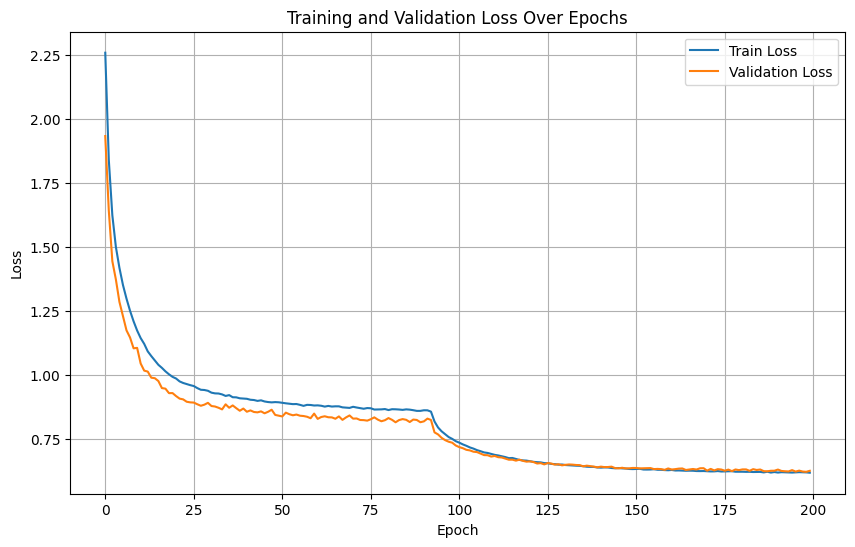

In [13]:
# Main
if __name__ == "__main__":
    # Mount Google Drive (nếu dùng Colab)
    #from google.colab import drive

    # Đường dẫn tới dữ liệu
    root_folder = "/content/emotion_train/Emotions"
    folders = [f for f in glob.glob(os.path.join(root_folder, "*")) if os.path.isdir(f)]
    all_files = []
    for folder in folders:
        all_files.extend(glob.glob(os.path.join(folder, "**", "*.wav"), recursive=True))

    # Kiểm tra phân bố nhãn
    emotion_map = {'Angry': 0, 'Happy': 1, 'Sad': 2, 'Neutral': 3, 'Disgusted': 4, 'Fearful': 5, 'Suprised': 6}
    y_raw = [emotion_map.get(os.path.basename(os.path.dirname(f)), -1) for f in all_files]
    print("Phân bố nhãn gốc:", Counter([EMOTIONS[i] for i in y_raw if i != -1]))

    # Chuẩn bị dữ liệu
    X, y = prepare_training_data(all_files, emotion_map)

    # Xây dựng và huấn luyện mô hình
    cnn_model = build_cnn_2d(input_shape=(26, 157, 1))
    cnn_model, history = train_and_evaluate_model(cnn_model, X, y,
                                                  epochs=200,
                                                  batch_size=16,
                                                  checkpoint_path='best_cnn_2d_vnemos.h5')

    # Lưu mô hình cuối cùng (tùy chọn)
    cnn_model.save('final_cnn_2d_vnemos.h5')

    # Vẽ biểu đồ Loss
    plot_loss_history(history)

In [14]:
    best_model = tf.keras.models.load_model('best_cnn_2d_vnemos.h5')
    root_folder_test = "/content/emotion_test/Emotions-test"
    folders_test = [f for f in glob.glob(os.path.join(root_folder_test, "*")) if os.path.isdir(f)]
    all_files_test = []
    for folder in folders_test:
        all_files_test.extend(glob.glob(os.path.join(folder, "**", "*.wav"), recursive=True))
    for test_path in all_files_test:
        predicted_emotion = predict_emotion(test_path, best_model)
        print(f"Dự đoán cảm xúc {os.path.basename(test_path)} (best model): {predicted_emotion}")

Dự đoán cảm xúc YAF_witch_happy.wav (best model): Happy
Dự đoán cảm xúc YAF_tell_happy.wav (best model): Happy
Dự đoán cảm xúc a06.wav (best model): Happy
Dự đoán cảm xúc a01.wav (best model): Happy
Dự đoán cảm xúc a05.wav (best model): Happy
Dự đoán cảm xúc YAF_wife_happy.wav (best model): Happy
Dự đoán cảm xúc YAF_turn_happy.wav (best model): Happy
Dự đoán cảm xúc YAF_wheat_happy.wav (best model): Happy
Dự đoán cảm xúc d01.wav (best model): Happy
Dự đoán cảm xúc YAF_tough_happy.wav (best model): Happy
Dự đoán cảm xúc a02.wav (best model): Happy
Dự đoán cảm xúc YAF_talk_happy.wav (best model): Happy
Dự đoán cảm xúc a15.wav (best model): Happy
Dự đoán cảm xúc YAF_walk_happy.wav (best model): Happy
Dự đoán cảm xúc YAF_thin_happy.wav (best model): Happy
Dự đoán cảm xúc YAF_third_happy.wav (best model): Happy
Dự đoán cảm xúc YAF_when_happy.wav (best model): Happy
Dự đoán cảm xúc YAF_team_happy.wav (best model): Happy
Dự đoán cảm xúc YAF_voice_happy.wav (best model): Happy
Dự đoán cảm xúc 

In order to use a GPU with your notebook, select the <code>Runtime &gt; Change runtime type</code> menu and then set the hardware accelerator to the desired option.

## More memory

Users who have purchased one of Colab's paid plans have access to high-memory VMs when they are available. More powerful GPUs are always offered with high-memory VMs.
You can see how much memory you have available at any time by running the following code cell. If the execution result of running the code cell below is 'Not using a high-RAM runtime', then you can enable a high-RAM runtime via <code>Runtime &gt; Change runtime type</code> in the menu. Then select High-RAM in the Runtime shape toggle button. After, re-execute the code cell.

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

## Longer runtimes

All Colab runtimes are reset after some period of time &#40;which is faster if the runtime isn't executing code&#41;. Colab Pro and Pro+ users have access to longer runtimes than those who use Colab free of charge.

## Background execution

Colab Pro+ users have access to background execution, where notebooks will continue executing even after you've closed a browser tab. This is always enabled in Pro+ runtimes as long as you have compute units available.


## Relaxing resource limits in Colab Pro

Your resources are not unlimited in Colab. To make the most of Colab, avoid using resources when you don't need them. For example, only use a GPU when required and close Colab tabs when finished.

If you encounter limitations, you can relax those limitations by purchasing more compute units via pay as you go. Anyone can purchase compute units via <a href="https://colab.research.google.com/signup">pay as you go</a>; no subscription is required.

## Send us feedback!

<p>If you have any feedback for us, please let us know. The best way to send feedback is by using the Help &gt; 'Send feedback…' menu. If you encounter usage limits in Colab Pro consider subscribing to Pro+.</p>
<p>If you encounter errors or other issues with billing &#40;payments&#41; for Colab Pro, Pro+ or pay as you go, please email <a href="mailto:colab-billing@google.com">colab-billing@google.com</a>.</p>

## More resources

### Working with notebooks in Colab
- [Overview of Colab](/notebooks/basic_features_overview.ipynb)
- [Guide to markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)

<a name="working-with-data"></a>
### Working with data
- [Loading data: Drive, Sheets and Google Cloud Storage](/notebooks/io.ipynb)
- [Charts: visualising data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

### Machine learning crash course
These are a few of the notebooks from Google's online machine learning course. See the <a href="https://developers.google.com/machine-learning/crash-course/">full course website</a> for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)


<a name="using-accelerated-hardware"></a>
### Using accelerated hardware
- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TPUs in Colab](/notebooks/tpu.ipynb)

<a name="machine-learning-examples"></a>

## Machine learning examples

To see end-to-end examples of the interactive machine learning analyses that Colab makes possible, take a look at these tutorials using models from <a href="https://tfhub.dev">TensorFlow Hub</a>.

A few featured examples:

- <a href="https://tensorflow.org/hub/tutorials/tf2_image_retraining">Retraining an Image Classifier</a>: Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- <a href="https://tensorflow.org/hub/tutorials/tf2_text_classification">Text Classification</a>: Classify IMDB film reviews as either <em>positive</em> or <em>negative</em>.
- <a href="https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization">Style Transfer</a>: Use deep learning to transfer style between images.
- <a href="https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa">Multilingual Universal Sentence Encoder Q&amp;A</a>: Use a machine-learning model to answer questions from the SQuAD dataset.
- <a href="https://tensorflow.org/hub/tutorials/tweening_conv3d">Video Interpolation</a>: Predict what happened in a video between the first and the last frame.
